<div
  style="
    display: flex;
    justify-content: center;
    flex-direction: column;
    align-items: center;
  "
>
<div style="width: 400px; padding: 20px; background: #111; border: 1px solid #333; color: #eee">
  <p style="opacity: 0.5; margin-bottom: -10px"><i>TDT4173 Machine Learning 2023</i></p>
  <h1 style="margin-bottom: -5px"><b>Long Notebook</b></h1>
  <h3>Kaggle Name: Neural Net Ninjas</h3>
  <br />
  <h3>Team Members:</h3>
  <table style="margin: 0 auto; width: 100%; text-align: left">
    <tr style="background: #222">
      <th style="border-width: 0.5px; border-color: #555">Name</th>
      <th style="border-width: 0.5px; border-color: #555">Student ID</th>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Antonsen Eggen, Sivert</td>
      <td style="border-width: 0.5px; border-color: #555">123 45 678</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Broch Grude, Kristoffer VI Nicolay</td>
      <td style="border-width: 0.5px; border-color: #555">123 45 678</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Raa, Mathias</td>
      <td style="border-width: 0.5px; border-color: #555">123 45 678</td>
    </tr>
  </table>
  </div>
</div>

---

### Outline
* [1 – Setup & Utils](#1)
* [2 – Exploratory Data Analysis](#2)
    * [2.1 – Data Overview](#2.1)
    * [2.2 – Data Cleaning](#2.2)
    * [2.3 – Data Visualization](#2.3)
* [3 – Preprocessing](#3)
    * [3.1 – Feature Selection](#3.1)
* [4 – Modeling](#4)
    * [4.1 – Model Selection](#4.1)
    * [4.2 – Model Evaluation](#4.2)
* [5 – Postprocessing](#5)
* [6 – Conclusion](#6)

# 1 – Setup & Utils

In [2]:
# Utils
from IPython.utils import io
import os

# Data
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_predict, KFold, train_test_split

# Models
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

import tensorflow as tf

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import scipy.optimize as opt

In [8]:
def scale_data(data, cols=None):
    """
    Scale model-data using MinMaxScaler
    """
    
    if cols is None:
        ignore_cols = [
            "location",
            "dew_or_rime:idx",
            "is_day:idx",
            "is_in_shadow:idx",
            "pv_measurement",
            "data_type",
        ]

        cols = [col for col in data.columns if col not in ignore_cols]

    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][cols]
    )
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][["pv_measurement"]]
    )

    data_copy = data.copy()

    data_copy[cols] = X_scaler.transform(data_copy[cols])
    data_copy[["pv_measurement"]] = y_scaler.transform(data[["pv_measurement"]])

    return data_copy, X_scaler, y_scaler

# 2 – Exploratory Data Analysis

## 2.1 – Domain Knowledge

#### Problem and provider

The problem is to build a model that can predict solar erngy production for every hour of the next day. 
The data provided is from ANEO, an energy producer and service provider with headquarters in Trondheim Norway

#### Domain

Solar energy is the energy that the sun gives trough radiation, and sun related statistics is therefore off course relevant for the electrity that solar panals are able to produce. Solar panels cannot convert 100% of the energy as their is some loss, and the sun radiation during a time period is thus an upper limit of what the production can be in that period. Radiation is blocked when there are clouds, thick weather like snow or rain amongst other things, so the scale of this things at given time periods will also affect solar panel production. In addition, since the sun goes down during the night, there is almost no clear radition, so energy production during the night will be lower or nothing at all. Thus, solar energy production is cyclic in it's nature. The same can be said for the different seasons, as there generally is higner radition during the summer than the winter, so the production might have seasonal differences.

The provided data consists of 3 different location A, B and C. Since the locations can have different installations of solar panels, there are probably differences in the amount that they produce just because of the scale of the operation at each location.

## 2.2 – Data Quality

### 2.2.1 Data Overview

Let's first load all datasets individually

In [4]:
# A
train_targets_a = pd.read_parquet('../data/A/train_targets.parquet')
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')

# B
train_targets_b = pd.read_parquet('../data/B/train_targets.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')

# C
train_targets_c = pd.read_parquet('../data/C/train_targets.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

No we can look at the each dataset just to see what they look like

Observed training data A

In [5]:
X_train_observed_a.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,...,342.834015,-3.202,0.0,285.899994,100.0,39640.101562,3.7,-3.6,-0.8,-0.0
1,2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,...,346.294006,-3.650,0.0,286.100006,100.0,40123.898438,3.6,-3.6,-0.6,-0.0
2,2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,...,349.768005,-3.998,0.0,286.299988,100.0,40628.300781,3.6,-3.6,-0.4,-0.0
3,2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,...,353.251007,-4.247,0.0,286.600006,100.0,41153.601562,3.5,-3.5,-0.2,-0.0
4,2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,...,356.742004,-4.393,0.0,286.799988,100.0,41699.898438,3.5,-3.5,0.0,-0.0


In [6]:
X_train_observed_a.shape

(118669, 46)

We can see that the A train observed set has 46 features and 118669 rows

Estimated train A

In [7]:
X_train_estimated_a.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2022-10-27 07:00:18,2022-10-28 22:00:00,8.4,1.233,1425.099976,0.0,0.0,1211.699951,1.0,281.399994,...,340.799011,-38.466999,0.0,284.700012,100.0,29429.699219,0.8,-0.4,0.7,-0.0
1,2022-10-27 07:00:18,2022-10-28 22:15:00,8.4,1.233,2085.899902,0.0,0.0,1560.500000,1.0,281.299988,...,345.451996,-38.955002,0.0,284.700012,100.0,23604.099609,0.7,-0.4,0.7,-0.0
2,2022-10-27 07:00:18,2022-10-28 22:30:00,8.3,1.233,2746.600098,0.0,0.0,1909.400024,1.0,281.200012,...,350.153015,-39.310001,0.0,284.700012,100.0,17799.800781,0.7,-0.3,0.6,-0.0
3,2022-10-27 07:00:18,2022-10-28 22:45:00,8.3,1.233,3407.399902,0.0,0.0,2258.199951,1.0,281.200012,...,354.886993,-39.528999,0.0,284.600006,100.0,12016.500000,0.6,-0.2,0.6,-0.0
4,2022-10-27 07:00:18,2022-10-28 23:00:00,8.2,1.233,4068.199951,0.0,0.0,2607.000000,1.0,281.100006,...,359.638000,-39.609001,0.0,284.600006,100.0,6254.399902,0.6,-0.1,0.6,-0.0


In [8]:
X_train_estimated_a.shape

(17576, 47)

We can see that the estimated set has one more feature, which is the date_calc coloumn

Test A

In [9]:
X_test_estimated_a.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,...,10.520000,-11.185,0.0,273.799988,80.699997,30210.699219,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,...,14.203000,-10.825,0.0,273.799988,77.000000,30003.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.287,912.700012,0.0,0.0,1068.300049,0.0,271.600006,...,17.868999,-10.360,0.0,273.799988,73.099998,29797.099609,3.9,2.1,3.3,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.287,912.700012,0.0,0.0,1081.900024,0.0,271.600006,...,21.514000,-9.794,0.0,273.799988,69.000000,29618.599609,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.400024,0.0,271.600006,...,25.135000,-9.128,0.0,273.799988,64.500000,29507.500000,3.9,2.0,3.3,-0.0


In [10]:
X_test_estimated_a.shape

(2880, 47)

Train targets A

In [11]:
train_targets_a.head()

,time,pv_measurement
0,2019-06-02 22:00:00,0.00
1,2019-06-02 23:00:00,0.00
2,2019-06-03 00:00:00,0.00
3,2019-06-03 01:00:00,0.00
4,2019-06-03 02:00:00,19.36


In [12]:
train_targets_a.shape

(34085, 2)

We can see that the train targets only has two features, the time and day, and the pv_measurement. 

There are two main discoveries here already:

1. The time features are every hour, but the train and test set hav rows for every 15 mins. This means that as a part of the preprocessing stage, we need to resample the data so that we get hours when training. 
2. There are 0 values in the pv_measurement coloumn. This might be because it is during the night, but is there really a reason that there should be 0 production at 1AM and then 19.36 at 2AM? This might indicate that we must look into cleaning some 0 values

Let's look at all location B

Observed train B

In [13]:
X_train_observed_b.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-01-01 00:00:00,5.6,1.239,1226.400024,0.0,0.0,1226.400024,0.0,275.399994,0.0,...,12.985000,-49.139999,0.0,278.399994,73.900002,19275.900391,2.5,1.1,2.2,-0.0
1,2019-01-01 00:15:00,5.6,1.239,1209.300049,0.0,0.0,1209.300049,0.0,275.200012,0.0,...,18.205999,-48.688000,0.0,278.299988,83.800003,17638.000000,2.7,1.2,2.4,-0.0
2,2019-01-01 00:30:00,5.5,1.240,1192.099976,0.0,0.0,1192.099976,0.0,275.100006,0.0,...,23.339001,-48.091000,0.0,278.200012,91.199997,16008.799805,2.9,1.2,2.7,-0.0
3,2019-01-01 00:45:00,5.4,1.241,1174.900024,0.0,0.0,1174.900024,0.0,274.899994,0.0,...,28.367001,-47.358002,0.0,278.100006,96.400002,14388.500000,3.1,1.2,2.9,-0.0
4,2019-01-01 01:00:00,5.4,1.241,1157.599976,0.0,0.0,1157.599976,0.0,274.700012,0.0,...,33.275002,-46.497002,0.0,278.000000,99.400002,12777.299805,3.4,1.3,3.1,-0.0


In [14]:
X_train_observed_b.shape

(116929, 46)

Estimated train B

In [15]:
X_test_estimated_b.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.3,1.283,912.299988,0.0,0.0,1039.900024,0.0,271.700012,...,10.521000,-11.184,0.0,273.799988,80.699997,31329.500000,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.283,912.299988,0.0,0.0,1053.099976,0.0,271.700012,...,14.204000,-10.824,0.0,273.799988,77.099998,31181.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.283,912.299988,0.0,0.0,1066.400024,0.0,271.600006,...,17.870001,-10.360,0.0,273.799988,73.199997,31033.599609,3.9,2.1,3.4,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.283,912.299988,0.0,0.0,1079.599976,0.0,271.600006,...,21.514000,-9.793,0.0,273.799988,69.000000,30885.699219,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.283,NaN,0.0,0.0,1092.900024,0.0,271.600006,...,25.135000,-9.127,0.0,273.799988,64.599998,30737.800781,3.9,2.0,3.3,-0.0


In [16]:
X_test_estimated_b.shape

(2880, 47)

Test B

In [17]:
X_test_estimated_b.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.3,1.283,912.299988,0.0,0.0,1039.900024,0.0,271.700012,...,10.521000,-11.184,0.0,273.799988,80.699997,31329.500000,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.283,912.299988,0.0,0.0,1053.099976,0.0,271.700012,...,14.204000,-10.824,0.0,273.799988,77.099998,31181.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.283,912.299988,0.0,0.0,1066.400024,0.0,271.600006,...,17.870001,-10.360,0.0,273.799988,73.199997,31033.599609,3.9,2.1,3.4,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.283,912.299988,0.0,0.0,1079.599976,0.0,271.600006,...,21.514000,-9.793,0.0,273.799988,69.000000,30885.699219,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.283,NaN,0.0,0.0,1092.900024,0.0,271.600006,...,25.135000,-9.127,0.0,273.799988,64.599998,30737.800781,3.9,2.0,3.3,-0.0


In [18]:
X_test_estimated_b.shape

(2880, 47)

Train targets B

In [19]:
train_targets_b.head()

,time,pv_measurement
0,2018-12-31 23:00:00,0.0
1,2019-01-01 00:00:00,0.0
2,2019-01-01 01:00:00,0.0
3,2019-01-01 02:00:00,0.0
4,2019-01-01 03:00:00,0.0


In [20]:
train_targets_b.shape

(32848, 2)

Lets look at C

Observed train C

In [21]:
X_train_observed_c.head()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-01-01 00:00:00,5.6,1.240,1153.599976,0.0,0.0,1153.599976,1.0,275.200012,0.0,...,12.989000,-49.178001,0.0,278.500000,68.500000,18220.400391,2.5,1.1,2.2,-0.0
1,2019-01-01 00:15:00,5.5,1.241,1137.900024,0.0,0.0,1137.900024,1.0,275.100006,0.0,...,18.214001,-48.724998,0.0,278.399994,80.800003,17083.699219,2.8,1.1,2.5,-0.0
2,2019-01-01 00:30:00,5.4,1.241,1122.199951,0.0,0.0,1122.199951,1.0,274.899994,0.0,...,23.351000,-48.127998,0.0,278.299988,89.900002,15940.900391,3.0,1.1,2.8,-0.0
3,2019-01-01 00:45:00,5.4,1.241,1106.400024,0.0,0.0,1106.400024,1.0,274.700012,0.0,...,28.382000,-47.393002,0.0,278.200012,96.099998,14792.000000,3.3,1.2,3.0,-0.0
4,2019-01-01 01:00:00,5.3,1.241,1090.599976,0.0,0.0,1090.599976,1.0,274.500000,0.0,...,33.292999,-46.529999,0.0,278.100006,99.400002,13637.299805,3.5,1.2,3.3,-0.0


In [22]:
X_train_observed_c.shape

(116825, 46)

Estimated train C

In [23]:
X_train_estimated_c.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2022-10-27 07:00:18,2022-10-28 22:00:00,8.3,1.231,1427.400024,0.0,0.0,1215.800049,1.0,281.200012,...,340.785004,-38.502998,0.0,285.200012,100.0,34387.398438,1.2,-0.3,1.1,-0.0
1,2022-10-27 07:00:18,2022-10-28 22:15:00,8.3,1.231,2089.000000,0.0,0.0,1425.900024,1.0,281.200012,...,345.440002,-38.992001,0.0,285.100006,100.0,27418.500000,1.2,-0.2,1.2,-0.0
2,2022-10-27 07:00:18,2022-10-28 22:30:00,8.3,1.231,2750.500000,0.0,0.0,1636.099976,1.0,281.100006,...,350.144012,-39.348000,0.0,285.100006,100.0,20508.800781,1.2,-0.1,1.2,-0.0
3,2022-10-27 07:00:18,2022-10-28 22:45:00,8.2,1.230,3412.100098,0.0,0.0,1846.199951,1.0,281.100006,...,354.880005,-39.567001,0.0,285.000000,100.0,13657.799805,1.2,-0.0,1.2,-0.0
4,2022-10-27 07:00:18,2022-10-28 23:00:00,8.2,1.230,4073.699951,0.0,0.0,2056.399902,1.0,281.100006,...,359.634003,-39.647999,0.0,285.000000,100.0,6865.000000,1.2,0.1,1.2,-0.0


In [24]:
X_train_estimated_c.shape

(17576, 47)

Test C

In [25]:
X_test_estimated_c.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.2,1.286,NaN,0.0,0.0,1178.000000,0.0,271.100006,...,10.519000,-11.223,0.0,273.700012,73.699997,31411.000000,3.5,1.5,3.1,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.2,1.286,NaN,0.0,0.0,1217.000000,0.0,271.100006,...,14.202000,-10.862,0.0,273.700012,70.800003,31295.800781,3.4,1.5,3.1,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.1,1.286,NaN,0.0,0.0,1256.000000,0.0,271.000000,...,17.868000,-10.397,0.0,273.700012,67.900002,31178.599609,3.4,1.4,3.1,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.1,1.286,NaN,0.0,0.0,1295.000000,0.0,270.899994,...,21.513000,-9.830,0.0,273.700012,64.800003,31082.500000,3.4,1.4,3.1,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.1,1.286,NaN,0.0,0.0,1334.099976,0.0,270.899994,...,25.134001,-9.163,0.0,273.700012,61.599998,31051.400391,3.4,1.4,3.1,-0.0


In [26]:
X_test_estimated_c.shape

(2880, 47)

Train targets C

In [27]:
train_targets_c.head()

,time,pv_measurement
0,2018-12-31 23:00:00,NaN
1,2019-01-01 00:00:00,NaN
2,2019-01-01 01:00:00,NaN
3,2019-01-01 02:00:00,NaN
4,2019-01-01 03:00:00,NaN


In [28]:
train_targets_c.shape

(32155, 2)

We can see that B and C have the same number of features and data structure as A. However there is a new key discovery:

 - The train targets in C contains NaN values. They should probably be cleaned, or perhaps filled with something else. 

#### 2.2.2 - Train targets EDA

Let's do some investigation at the train targets for A, B and C respectively.

Plotting train targets A

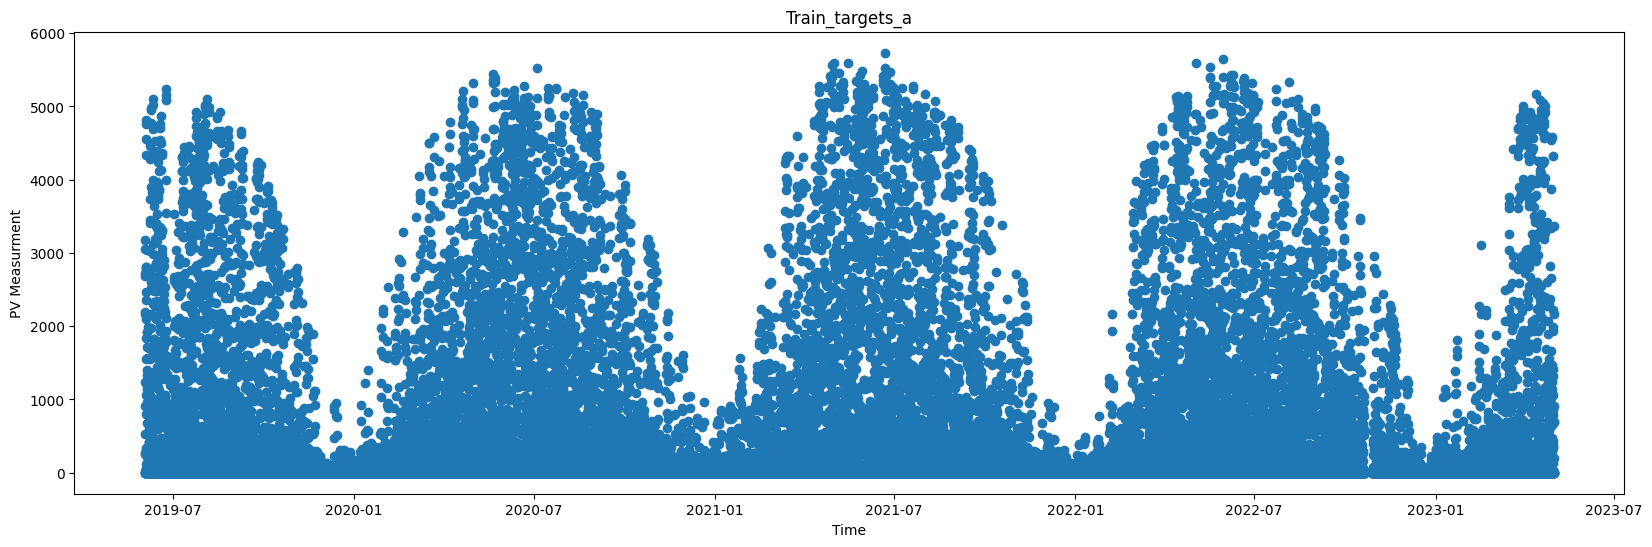

In [29]:
#plotting train_targets_a
plt.figure(figsize=(20,6))
plt.scatter(train_targets_a["time"], train_targets_a["pv_measurement"])
plt.xlabel("Time")
plt.ylabel("PV Measurment")
plt.title("Train_targets_a")
plt.show()

We can see a general trend of lower measurements around January (the winter). Possibly due to snow, or just lower radiation and less production during the winter. 

It's har to see smaller trends, so let's look at some smaller scales for A

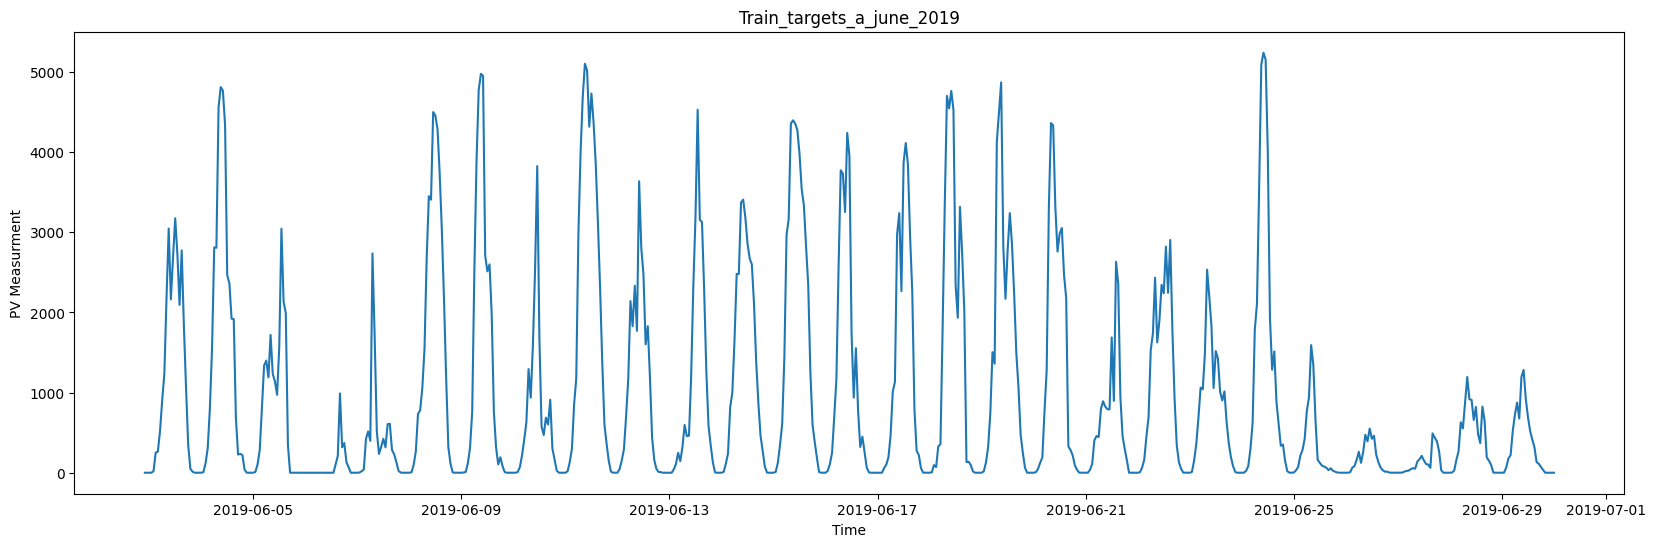

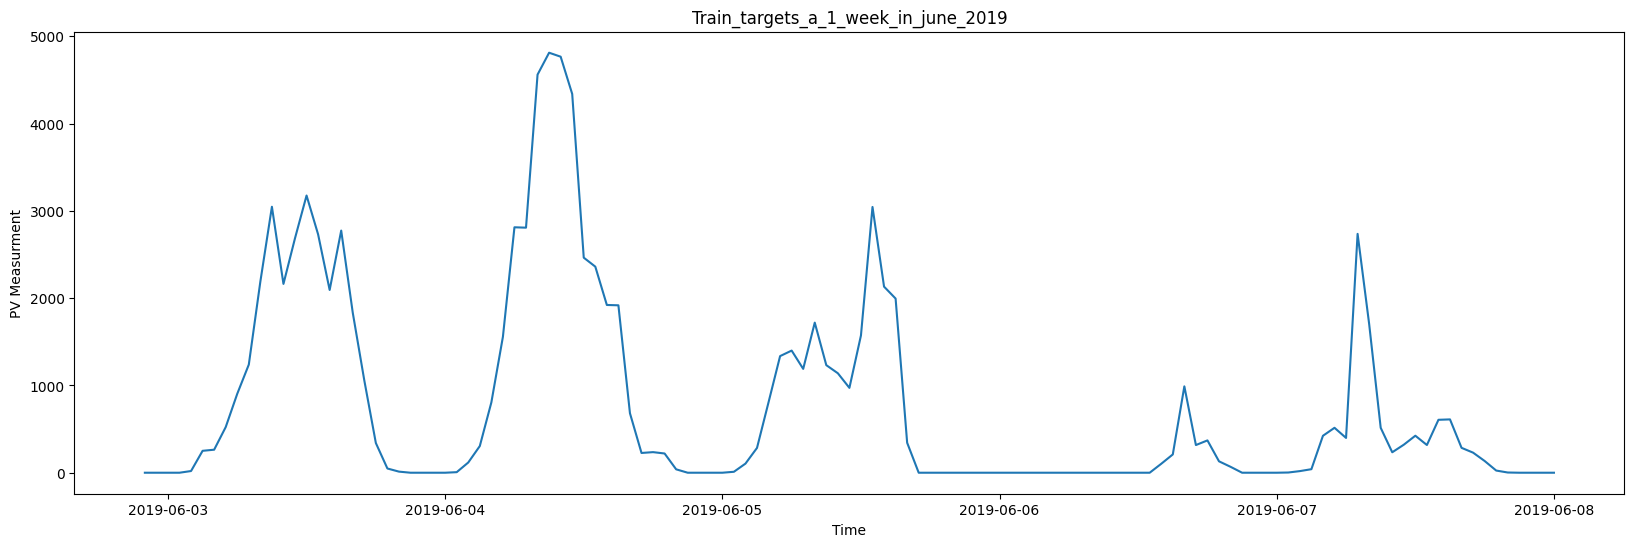

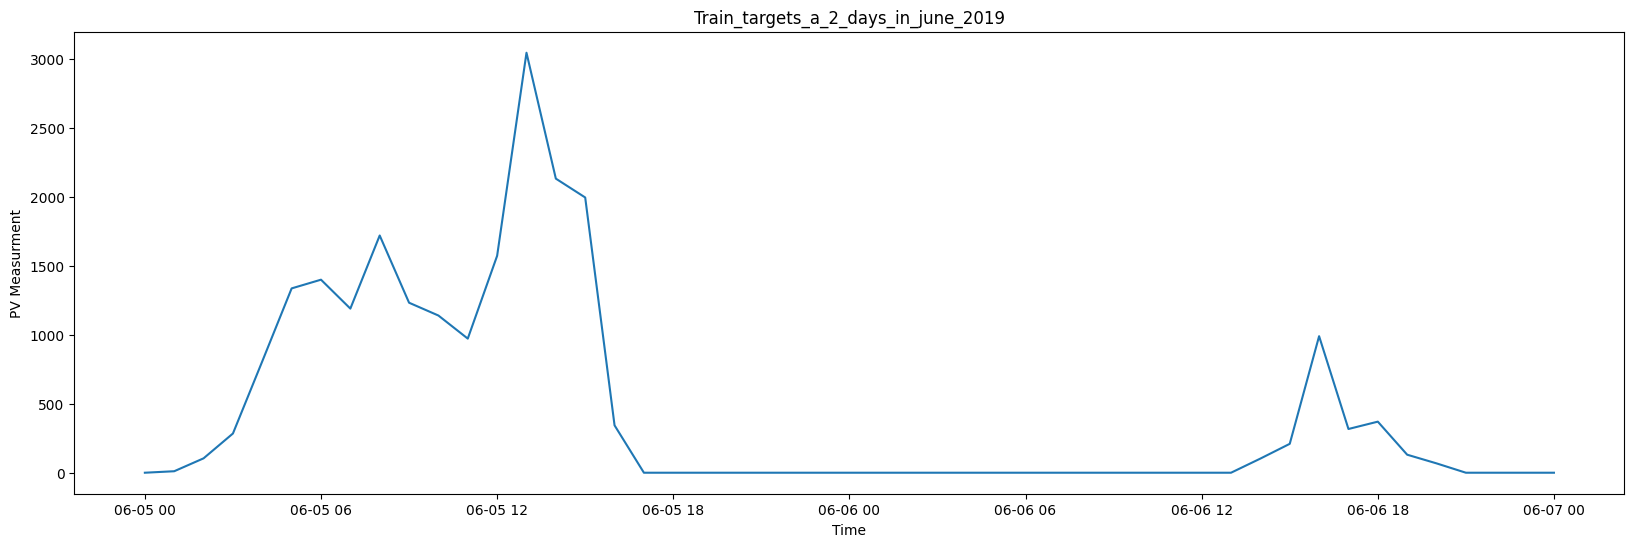

In [30]:
#plotting A targets for a month, week, and two days

for day in ["30", "08", "07"]:
    if day!="07":
        start_date = pd.Timestamp('2019-06-01')
        end_date = pd.Timestamp('2019-06-'+day)
        filtered_train_targets_a = train_targets_a[(train_targets_a['time'] >= start_date) & (train_targets_a['time'] <= end_date)]
        plt.figure(figsize=(20, 6))
        plt.plot(filtered_train_targets_a["time"], filtered_train_targets_a["pv_measurement"])
        plt.xlabel("Time")
        plt.ylabel("PV Measurment")
        if day=="30":
            plt.title("Train_targets_a_june_2019")
            plt.show()
        else:
            plt.title("Train_targets_a_1_week_in_june_2019")
            plt.show()
    else:
        start_date = pd.Timestamp('2019-06-05')
        end_date = pd.Timestamp('2019-06-'+day)
        filtered_train_targets_a = train_targets_a[(train_targets_a['time'] >= start_date) & (train_targets_a['time'] <= end_date)]
        plt.figure(figsize=(20, 6))
        plt.plot(filtered_train_targets_a["time"], filtered_train_targets_a["pv_measurement"])
        plt.xlabel("Time")
        plt.ylabel("PV Measurment")
        plt.title("Train_targets_a_2_days_in_june_2019")
        plt.show()

We can see from this plot that on a monthly scale the pv_measurements move up and down and seem to have a general pattern where there are 0 measurements and where there are peaks. 

Zooming in on a week and a day, we can see that there seems to be some irregularities. For example, why does the 6'th have som many repeating 0 measurements. Is there a reason that there on a summer day in June at 12 o'clock should be 0 production when the day before had a lot of production at 12? It indicate that there are some errors in the measurements, where repeated valeus over a long period of time has to be cleaned. 

Let's look at B and C

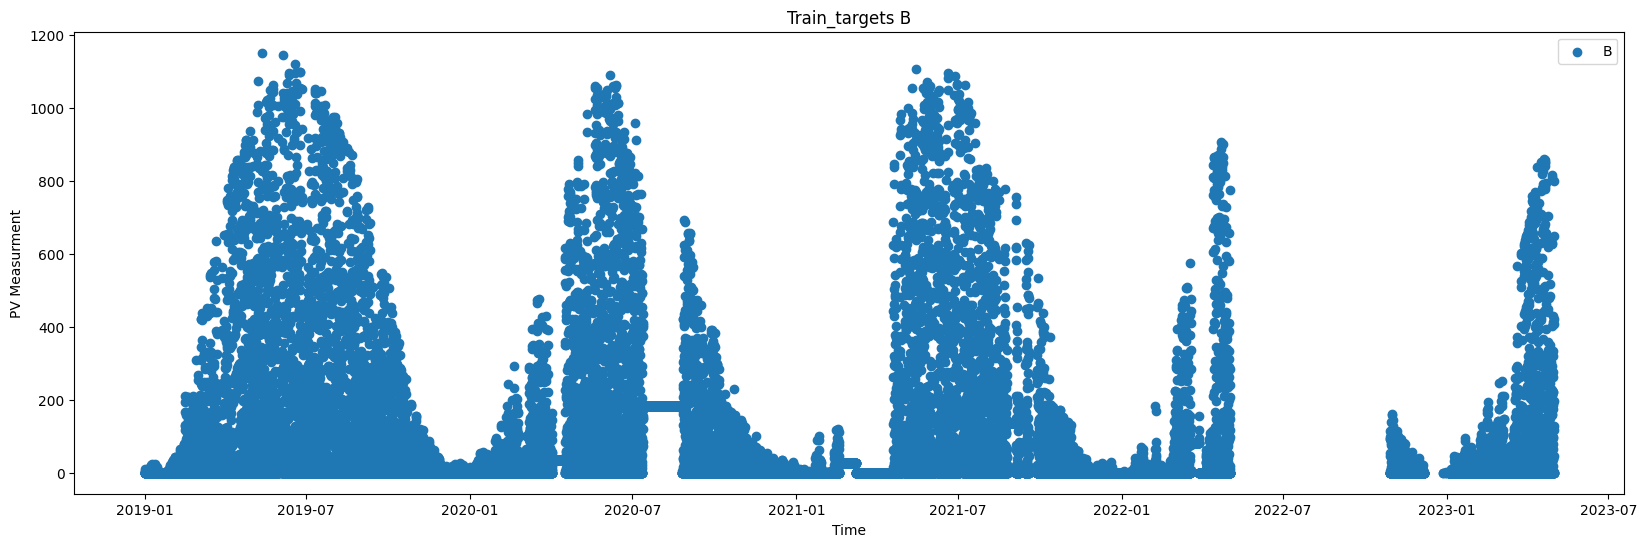

In [31]:
#B
plt.figure(figsize=(20,6))
plt.scatter(train_targets_b["time"], train_targets_b["pv_measurement"], label="B")
plt.legend()
plt.xlabel("Time")
plt.ylabel("PV Measurment")
plt.title("Train_targets B")
plt.show()

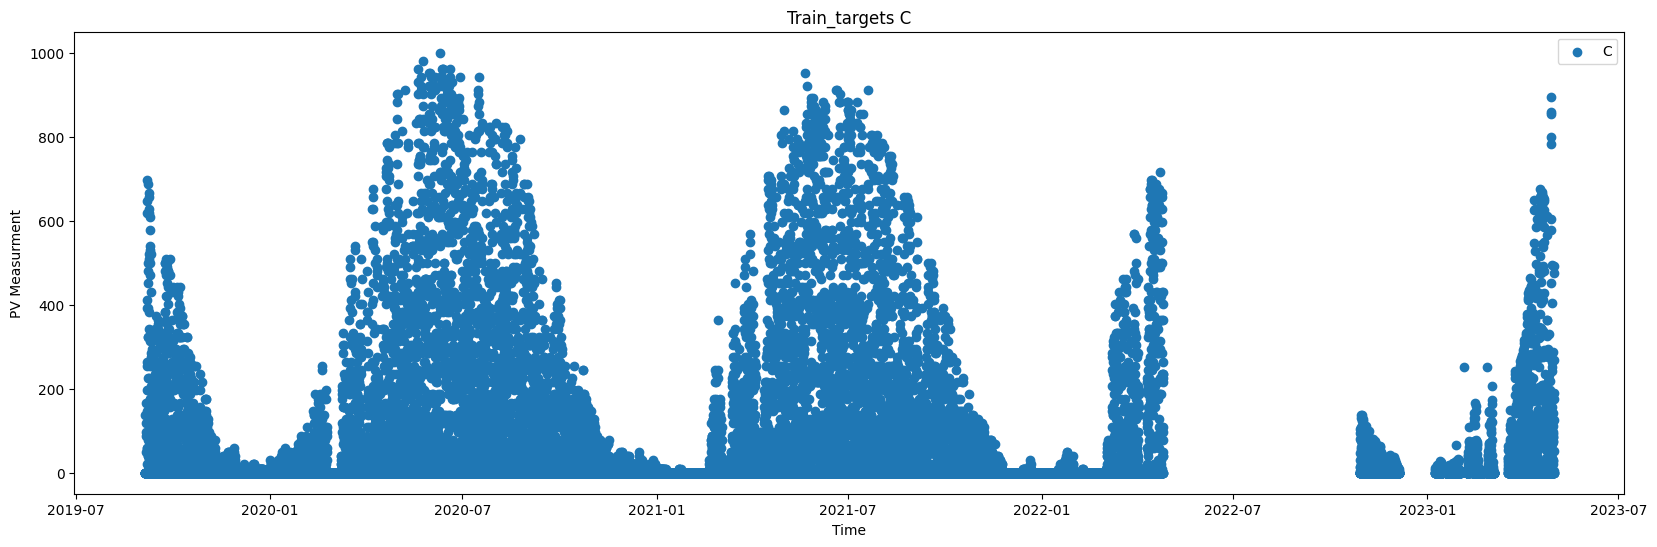

In [32]:
#C
plt.figure(figsize=(20,6))
plt.scatter(train_targets_c["time"], train_targets_c["pv_measurement"], label="C")
plt.legend()
plt.xlabel("Time")
plt.ylabel("PV Measurment")
plt.title("Train_targets C")
plt.show()

We can see that there are some key discoveries for B and C

1. In B there are two huge gaps of non-zero repeating values, these needs to be cleaned for sure
2. There is a huge time gap with no data towards the end

Let's plot all train targets on top of eachother

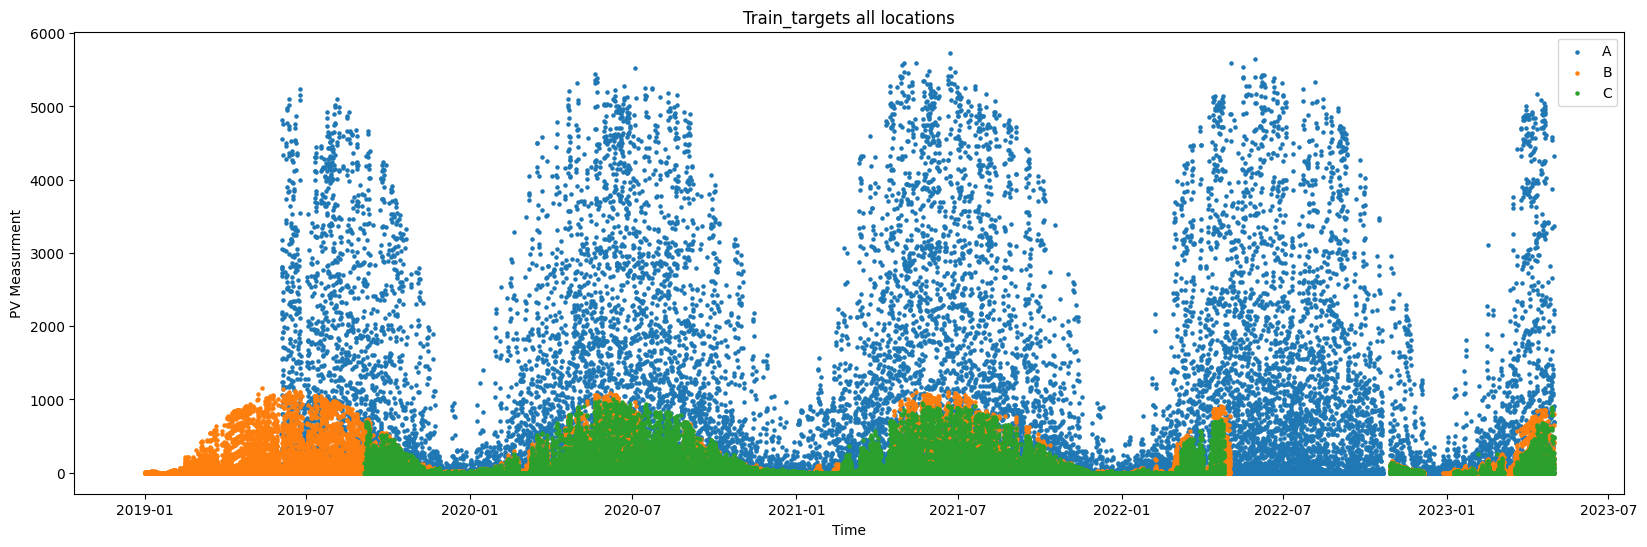

In [33]:
#plotting all train targets up against eachother
plt.figure(figsize=(20,6))
plt.scatter(train_targets_a["time"], train_targets_a["pv_measurement"], label="A",s=5)
plt.scatter(train_targets_b["time"], train_targets_b["pv_measurement"], label="B",s=5)
plt.scatter(train_targets_c["time"], train_targets_c["pv_measurement"], label="C",s=5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PV Measurment")
plt.title("Train_targets all locations")
plt.show()


We can se that the pv_measurements are a lot higher for location A, while B and see seems to have about the same scale on their measurement. 

Let's look at the number of zeros and number of NaN values in each of the locations

In [38]:
#counting the number of rows, and zero-measurement rows in traintargets_a
train_targets_a_0_pvs = train_targets_a[train_targets_a["pv_measurement"] == 0]
count_targett_pvs_0 = len(train_targets_a_0_pvs)
print("Number of rows in train_targets_a with 0 measurments: ", count_targett_pvs_0)

# NaN in A
train_target_a_Nan_pvs = train_targets_a[pd.isna(train_targets_a["pv_measurement"])]
count_target_nan_a = len(train_target_a_Nan_pvs)
print("Number of rows in train_targets_a with NaN measurments: ", count_target_nan_a)

#B
train_targets_b_0_pvs = train_targets_b[train_targets_b["pv_measurement"] == 0]
train_targets_b_negative_pvs = train_targets_b[train_targets_b["pv_measurement"] < 0]
train_target_b_Nan_pvs = train_targets_b[pd.isna(train_targets_b["pv_measurement"])]
count_targett_pvs_0_b = len(train_targets_b_0_pvs)
count_target_negative_b = len(train_targets_b_negative_pvs)
count_target_nan_b = len(train_target_b_Nan_pvs)
print("Number of rows in train_targets_b with 0 measurments: ", count_targett_pvs_0_b)
print("Number of rows in train_targets_b with negative measurments: ", count_target_negative_b)
print("Number of rows in train_targets_b with NaN measurments: ", count_target_nan_b)


#C

train_targets_c_0_pvs = train_targets_c[train_targets_c["pv_measurement"] == 0]
train_targets_c_negative_pvs = train_targets_c[train_targets_c["pv_measurement"] < 0]
train_target_c_Nan_pvs = train_targets_c[pd.isna(train_targets_c["pv_measurement"])]
count_targett_pvs_0_c = len(train_targets_c_0_pvs)
count_target_negative_c = len(train_targets_c_negative_pvs)
count_target_nan_c = len(train_target_c_Nan_pvs)
print("Number of rows in train_targets_c with 0 measurments: ", count_targett_pvs_0_c)
print("Number of rows in train_targets_c with negative measurments: ", count_target_negative_c)
print("Number of rows in train_targets_c with NaN measurments: ", count_target_nan_c)

Number of rows in train_targets_a with 0 measurments:  16040
Number of rows in train_targets_a with NaN measurments:  0
Number of rows in train_targets_b with 0 measurments:  17312
Number of rows in train_targets_b with negative measurments:  0
Number of rows in train_targets_b with NaN measurments:  4
Number of rows in train_targets_c with 0 measurments:  15952
Number of rows in train_targets_c with negative measurments:  0
Number of rows in train_targets_c with NaN measurments:  6060


There are 2 key takeaways from this:

1. There seems to be more or less equal amounts of 0 values in all locations, and that they are not uncommon. 
2. While A has no NaN values and B have only 4, C have 6060 which is a huge amount. This is probably therefore a error that needs to be cleaned away

Next, wee need to see if there are some negative values. There should not be negative values, as it is impossible to produce negative energy

In [39]:
#counting the number of negative rows
train_targets_a_negative_pvs = train_targets_a[train_targets_a["pv_measurement"] < 0]
count_target_negative_a = len(train_targets_a_negative_pvs)
print("Number of rows in train_targets_a with negative measurments: ", count_target_negative_a)


train_targets_b_negative_pvs = train_targets_b[train_targets_b["pv_measurement"] < 0]
count_target_negative_b = len(train_targets_b_negative_pvs)
print("Number of rows in train_targets_b with negative measurments: ", count_target_negative_b)

#counting the number of negative rows
train_targets_c_negative_pvs = train_targets_c[train_targets_c["pv_measurement"] < 0]
count_target_negative_c = len(train_targets_c_negative_pvs)
print("Number of rows in train_targets_c with negative measurments: ", count_target_negative_c)

Number of rows in train_targets_a with negative measurments:  0
Number of rows in train_targets_b with negative measurments:  0
Number of rows in train_targets_c with negative measurments:  0


There are no negative values, which is good!

## 2.4 – Feature Exploration

## 2.5 – Aggregations

# 3 – Preprocessing

# 4 – Modeling

# 5 – Postprocessing